In [2]:
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import pandas as pd


# 初期条件

In [3]:
sns.set_style("whitegrid")

In [4]:
N = 40
F = 8.0
x0 = F * np.ones(N)
x0[0] += 0.01

In [5]:
def l96_model(x):
    d = np.zeros(N)
    for i in range(N):
        d[i] = (x[(i+1)%N] - x[i-2]) * x[i-1] - x[i] + F
    return d


def l96_step(x, dt):
    k1 = l96_model(x) * dt
    k2 = l96_model(x + k1/2) * dt
    k3 = l96_model(x + k2/2) * dt
    k4 = l96_model(x + k3) * dt
    x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return x


In [6]:
def l96_loop(x0, t_end):
    t = 0.0
    dt = 0.01
    x_ls = []
    x_ls.append(x0)
    x = x0

    while(t + dt<= t_end):
        x = l96_step(x, dt)
        x_ls.append(x)
        t += dt
    x_ls = np.array(x_ls)
    return x_ls
def l96_jump(x0, t_end):
    return l96_loop(x0, t_end)[-1]
def l96_one(x0):
    return l96_loop(x0, 0.01)[-1]
def l96_synoptic(x0):
    return l96_loop(x0, 0.05)[-1]

In [7]:
def RMSE(veca, vecb, ax = 0):
    return np.sqrt(((veca - vecb)**2).mean(axis=ax))


In [8]:
def random_xa(x):
    randt = 10.0
    noise = random.random()
    return l96_jump(x+noise, randt)

In [9]:
x_ls = l96_loop(x0, 10.0)

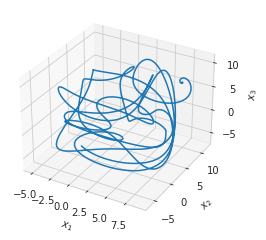

In [10]:
# Plot the first three variables
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(x_ls[:, 0], x_ls[:, 1], x_ls[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

## リアプノフ指数の計算
正確にやるためには何が必要？

->　アトラクター上の様々な点から計測する

とりあえず1年分スピンアップで捨てた後ノイズを加えたものと加えていないものの誤差を測定する

In [11]:
year = 73.0
ly_data = l96_loop(x0, 10 * year)

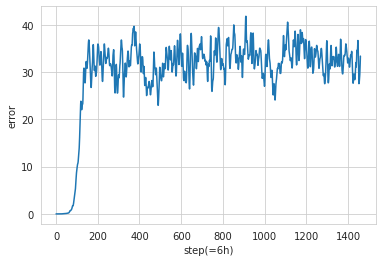

In [11]:
y = 1.0
#while y <= 10.0:
base = ly_data[int(y * year * 100)]
noise = np.zeros_like(base)
noise[0] += 0.01
out = l96_loop(base, year) - l96_loop(base+noise, year)
out = np.linalg.norm(out,axis=1)
plt.plot(out[::5])
plt.xlabel('step(=6h)')
plt.ylabel('error')
plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

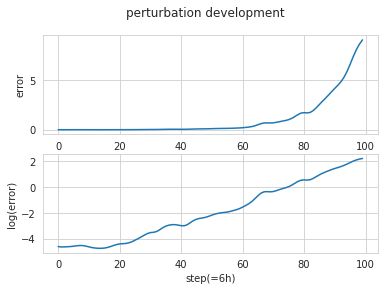

In [12]:
out_zoom = out[:500]
out_zoom = out_zoom[::5]
fig, ax = plt.subplots(2)
fig.suptitle('perturbation development')
ax[0].plot(out_zoom)
ax[1].plot(np.log(out_zoom))
ax[1].set_xlabel('step(=6h)')
ax[0].set_ylabel('error')
ax[1].set_ylabel('log(error)')
plt.show

リアプノフ指数>0であることがわかった。つまりカオスであると定義される。

しかし200step付近で誤差の成長が止まる。この誤差は２つの適当なアトラクターの平均的な差に当たるものだと考える。

# 2年分足し合わせる
2 * 365 * 4 * 0.05 = 146.0 step必要

In [12]:
twoy = 146.0
data = l96_loop(x0, twoy)
print(data.shape)
data = data[::5] # 6hごとに圧縮
data = data[int(data.shape[0]/2):] # ２年めのみを使う
print(data.shape)

(14600, 40)
(1460, 40)


In [13]:
print(data[0])

[ 3.73972009  5.0818905   1.8831919  -2.96759682  2.09667497  2.91926057
 10.26754184 -2.61767505 -1.20824939 -0.99769068  2.17496582  6.47420229
  1.27741554 -3.35782869 -0.17156987 -5.28834285 -0.36133256  9.38708514
  7.02829646  6.1431077   4.03196919 -2.69435818  3.45771701 11.95515543
  1.45649789 -1.06537432  1.35330969 -0.17528414  2.55640281  6.3852554
  6.18010162  1.696851   -1.87662797 -0.11911194  4.66623823  9.10878121
  0.22889094  1.16859856 -1.66642582  1.60676217]


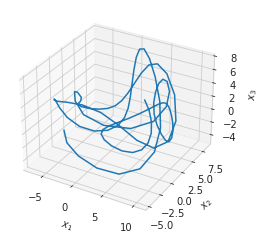

In [14]:
# Plot the first three variables
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data[:100, 0], data[:100, 1], data[:100, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

[-0.37088866 -1.05740036  0.96694758 -0.63378372 -0.11846755 -0.98110902
 -2.07854645 -0.94428604 -1.08294582  0.6327388  -0.60342722 -0.19593278
 -0.46759583 -1.10242792  1.29432874  0.8052844   1.99578819 -1.17914671
  0.20893948 -0.39111564  0.24604863  0.93597574 -1.11145026 -0.7509889
  0.16171652 -0.21090302  0.2938811  -1.30286613 -0.63999216  0.43137668
 -1.62463279  0.97201588 -2.04464096  0.00667666  0.45788046  0.94751802
  1.0080746   0.11001491  1.20981931  0.66466901]


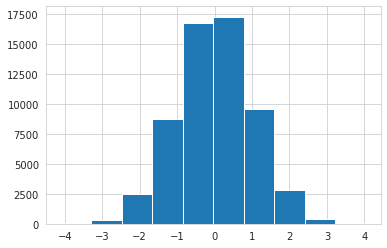

In [15]:
random_ls = np.random.randn(data.shape[0], data.shape[1])
print(random_ls[0])
plt.hist(np.ravel(random_ls))
plt.show()

In [16]:
data_noise = data + random_ls
np.savetxt("data/data.txt", data)
np.savetxt("datadata_noise.txt", data_noise)

In [17]:
# if data exists
data_noise = np.loadtxt("data/data_noise.txt")
data = np.loadtxt("data/data.txt")

# KF

In [18]:
a = 25
delta = 0.0001

In [20]:
x_s = data_noise[0]
p_s = a * np.eye(N)
x_a = random_xa(x_s)
p_a = a * np.eye(N)
H = np.eye(N)
R = np.eye(N)
error_x_ls = []
p_ls = []
noise_ls = []
error_x_ls.append(RMSE(x_a, data[0]))
p_ls.append(np.trace(p_a))
noise_ls.append(RMSE(data_noise[0], data[0]))

for i in range(1,500):#data_noise.shape[0]
    if i % 200 == 0:
        print(i)
    m = np.zeros((N, N))
    for j in range(0, N):
        e_j = np.zeros((N))
        e_j[j] = delta
        m[:, j] = (l96_synoptic(x_a + e_j) - l96_synoptic(x_a)) / delta
    x_f = l96_synoptic(x_a)
    p_f = m @ p_a @ m.T
    K = p_f @ H.T @ np.linalg.inv(H @ p_f @ H.T + R)
    x_a = x_f + K @ (data_noise[i] - H @ x_f)
    p_a = (np.eye(N) - K @ H) @ p_f
    p_a = p_a * 1.2
    error_x_ls.append(RMSE(x_a, data[i]))
    p_ls.append(np.trace(p_a))
    noise_ls.append(RMSE(data_noise[i], data[i]))

200
400


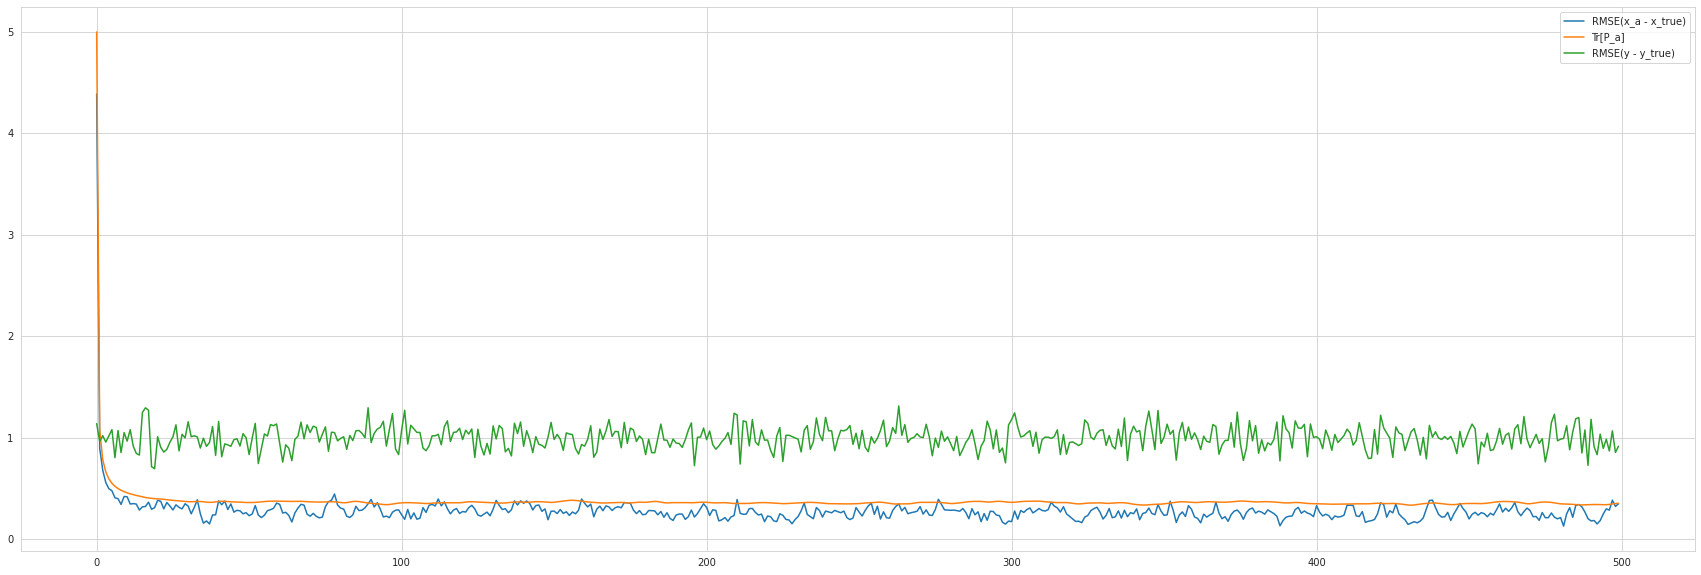

In [22]:
error_x_np = np.array(error_x_ls)
p_np = np.sqrt(np.array(p_ls) / N)
noise_np = np.array(noise_ls)
plt.figure(figsize=(30, 10))
plt.plot(error_x_np, label="RMSE(x_a - x_true)")
plt.plot(p_np, label="Tr[P_a]")
plt.plot(noise_np, label="RMSE(y - y_true)")
plt.legend()
plt.savefig("graph/kf_param.png")
plt.show()


In [23]:
error_x_np[400:].mean()

0.25196833727118484

### 

# インフレーションを変えて実験

In [24]:
def inflation(param):
    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    H = np.eye(N)
    R = np.eye(N)
    error_x_ls = []
    p_ls = []
    noise_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))
    p_ls.append(np.trace(p_a))
    noise_ls.append(RMSE(data_noise[0], data[0]))

    for i in range(1,600):#data_noise.shape[0]
        if i % 200 == 0:
            print(i)
        m = np.zeros((N, N))
        for j in range(0, N):
            e_j = np.zeros((N))
            e_j[j] = delta
            m[:, j] = (l96_synoptic(x_a + e_j) - l96_synoptic(x_a)) / delta
        x_f = l96_synoptic(x_a)
        p_f = m @ p_a @ m.T
        K = p_f @ H.T @ np.linalg.inv(H @ p_f @ H.T + R)
        x_a = x_f + K @ (data_noise[i] - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        p_a = p_a * param
        error_x_ls.append(RMSE(x_a, data[i]))
        p_ls.append(np.trace(p_a))
        noise_ls.append(RMSE(data_noise[i], data[i]))
    error_x_np = np.array(error_x_ls)
    return error_x_np[200:].mean()

In [25]:
num_infls = 10
infl_param_ls = np.linspace(1.0, 1.5, num_infls)
infl_error_ls = np.zeros((num_infls))
for i in range(num_infls):
    print("start infl {}".format(infl_param_ls[i]))
    infl_error_ls[i] = inflation(infl_param_ls[i])

start infl 1.0


KeyboardInterrupt: 

In [ ]:
infl_error_np = np.array(infl_error_ls)
np.savetxt("data/infl_error", infl_error_np)
np.savetxt("data/infl_param", infl_param_ls)

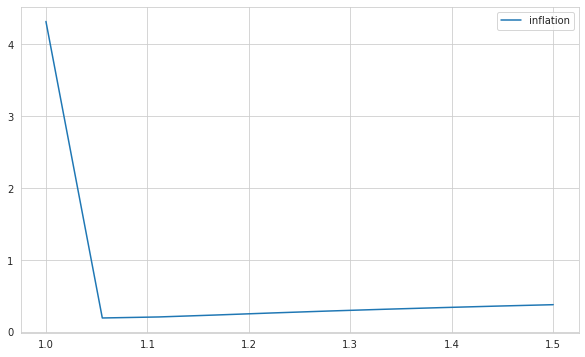

In [54]:
infl_error_np = np.loadtxt("data/infl_error")
infl_param_ls = np.loadtxt("data/infl_param")
plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(infl_param_ls, infl_error_np, label="inflation")
plt.legend()
plt.savefig("graph/infl.png")
plt.show()


In [ ]:
infl_error_np

# 3D-Var


In [ ]:

x_s = data_noise[0]
p_s = a * np.eye(N)
x_a = random_xa(x_s)
p_a = a * np.eye(N)
H = np.eye(N)
R = np.eye(N)
B = 1 * np.eye(N)
error_x_ls = []
p_ls = []
noise_ls = []
error_x_ls.append(RMSE(x_a, data[0]))
p_ls.append(np.trace(p_a))
noise_ls.append(RMSE(data_noise[0], data[0]))

for i in range(1,600):#data_noise.shape[0]
    if i % 200 == 0:
        print(i)
    x_f = l96_synoptic(x_a)
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    x_a = x_f + K @ (data_noise[i] - H @ x_f)
    p_a = (np.eye(N) - K @ H) @ p_f
    error_x_ls.append(RMSE(x_a, data[i]))
    noise_ls.append(RMSE(data_noise[i], data[i]))

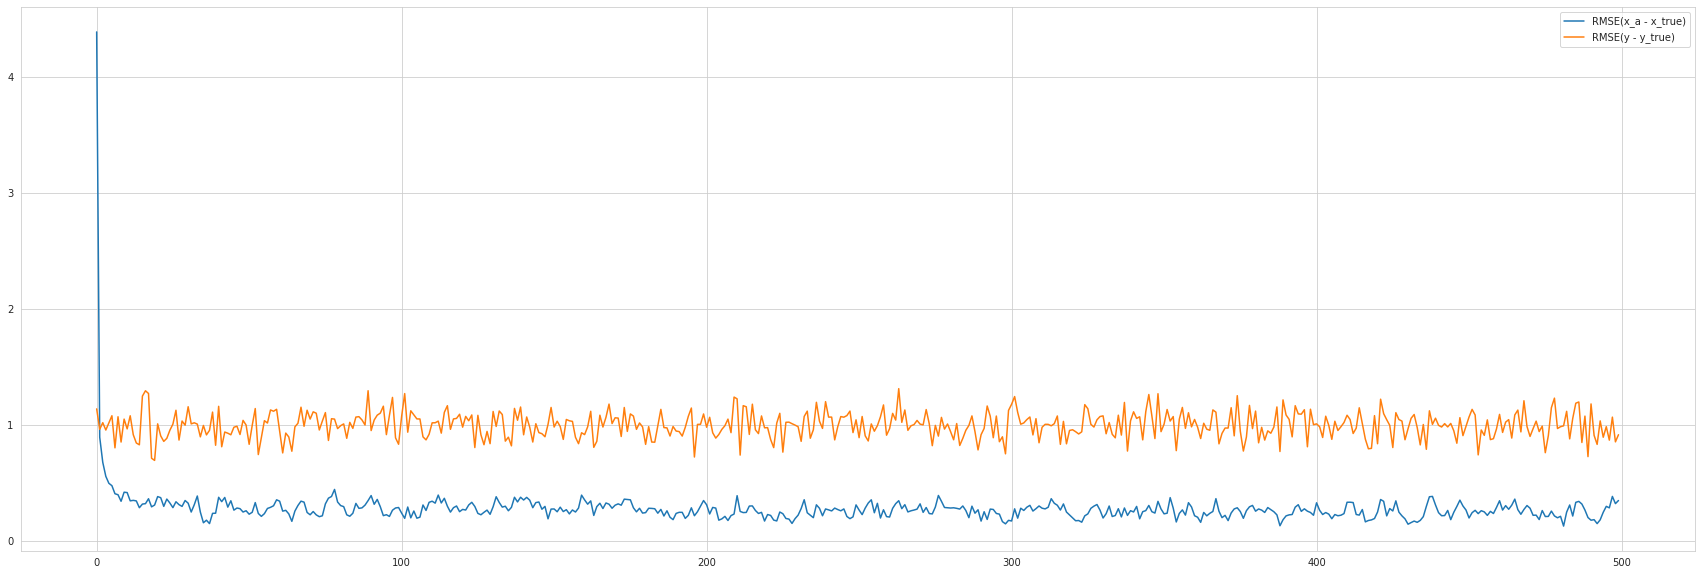

In [112]:
error_x_np = np.array(error_x_ls)
noise_np = np.array(noise_ls)
plt.figure(figsize=(30, 10))
plt.plot(error_x_np, label="RMSE(x_a - x_true)")
plt.plot(noise_np, label="RMSE(y - y_true)")
plt.legend()
plt.savefig("graph/3dvar.png")
plt.show()

In [ ]:
def searchb(param):

    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    H = np.eye(N)
    R = np.eye(N)
    B = param * np.eye(N)
    error_x_ls = []
    p_ls = []
    noise_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))
    p_ls.append(np.trace(p_a))
    noise_ls.append(RMSE(data_noise[0], data[0]))

    for i in range(1,600):#data_noise.shape[0]
        x_f = l96_synoptic(x_a)
        K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
        x_a = x_f + K @ (data_noise[i] - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        error_x_ls.append(RMSE(x_a, data[i]))
        noise_ls.append(RMSE(data_noise[i], data[i]))
    error_x_np = np.array(error_x_ls)
    return error_x_np[200:].mean()

In [ ]:
num_b = 10
b_param_ls = np.arange(0.1, 1.1 , 0.1)
b_error_ls = np.zeros((num_b))
for i in range(num_b):
    print("start infl {}".format(b_param_ls[i]))
    b_error_ls[i] = searchb(b_param_ls[i])

In [ ]:
b_param_ls

In [ ]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(b_param_ls, b_error_ls, label="b")
plt.legend()
plt.savefig("graph/b.png")
plt.show()


# NMC

# 解析アンサンブル

In [26]:
def del_tvar(del_num, param):
    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    del_key = np.random.choice(N, del_num, replace=False)
    H = np.eye(N)
    H = np.delete(H, del_key, 0)
    R = np.eye(N - del_num)
    B = param * np.eye(N)
    
    error_x_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))

    for i in range(1,600):#data_noise.shape[0]
        x_f = l96_synoptic(x_a)
        K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
        y = np.delete(data_noise[i], del_key)
        x_a = x_f + K @ (y - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        
        error_x_ls.append(RMSE(x_a, data[i]))
    error_x_np = np.array(error_x_ls)
    return error_x_np[200:].mean()

# 観測を抜く 3d-var

In [ ]:
num_b = 15
try_num = 2
error_ls_b = np.zeros((N, num_b))

for del_num in range(0, N):
    b_param_ls = np.linspace(0.1, 5.0 , num_b)
    for i in range(num_b):
        error_ls_b[del_num, i] = del_tvar(del_num, b_param_ls[i])

In [ ]:
np.save('data/3dvar.npy', error_ls_b)

In [151]:
error_ls_b = np.load('data/3dvar.npy')

In [152]:
error_ls_b.shape

(40, 15)

In [153]:
error_ls_b[0]

array([0.77906286, 0.44013511, 0.53362248, 0.6006414 , 0.65022981,
       0.68845118, 0.71887025, 0.74369094, 0.76434979, 0.78182534,
       0.79680863, 0.80980234, 0.82118139, 0.83123139, 0.84017387])

In [154]:
error_min_ls_b = error_ls_b.min(axis=1)

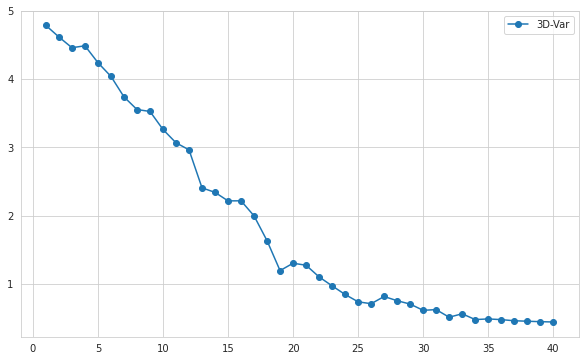

In [156]:
plt.plot(np.arange(1,41, 1), error_min_ls_b[::-1], marker='o',label="3D-Var")
plt.legend()
plt.show()

In [157]:
def del_tvar_random(del_num, param):
    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    R = np.eye(N - del_num)
    B = param * np.eye(N)
    
    error_x_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))

    for i in range(1,600):#data_noise.shape[0]
        del_key = np.random.choice(N, del_num, replace=False)
        H = np.eye(N)
        H = np.delete(H, del_key, 0)
        x_f = l96_synoptic(x_a)
        K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
        y = np.delete(data_noise[i], del_key)
        x_a = x_f + K @ (y - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        
        error_x_ls.append(RMSE(x_a, data[i]))
    error_x_np = np.array(error_x_ls)
    return error_x_np[200:].mean()

In [158]:
num_b = 15
try_num = 2
error_ls_b = np.zeros((N, num_b))

for del_num in range(0, N):
    b_param_ls = np.linspace(0.1, 5.0 , num_b)
    for i in range(num_b):
        error_ls_b[del_num, i] = del_tvar_random(del_num, b_param_ls[i])

In [ ]:
np.save('data/3dvar-random.npy', error_ls_b)

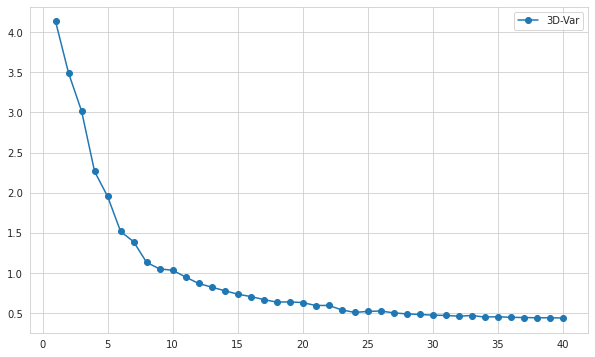

In [159]:
error_min_ls_b = error_ls_b.min(axis=1)
plt.plot(np.arange(1,41, 1), error_min_ls_b[::-1], marker='o',label="3D-Var")
plt.legend()
plt.show()

In [162]:
def del_tvar_fix(del_num, param):
    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    del_key = np.arange(del_num)
    H = np.eye(N)
    H = np.delete(H, del_key, 0)
    R = np.eye(N - del_num)
    B = param * np.eye(N)
    
    error_x_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))

    for i in range(1,600):#data_noise.shape[0]
        x_f = l96_synoptic(x_a)
        K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
        y = np.delete(data_noise[i], del_key)
        x_a = x_f + K @ (y - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        
        error_x_ls.append(RMSE(x_a, data[i]))
    error_x_np = np.array(error_x_ls)
    return error_x_np[200:].mean()

In [163]:
num_b = 15
try_num = 2
error_ls_b = np.zeros((N, num_b))

for del_num in range(0, N):
    b_param_ls = np.linspace(0.1, 5.0 , num_b)
    for i in range(num_b):
        error_ls_b[del_num, i] = del_tvar_fix(del_num, b_param_ls[i])

In [164]:
np.save('data/3dvar-fix.npy', error_ls_b)

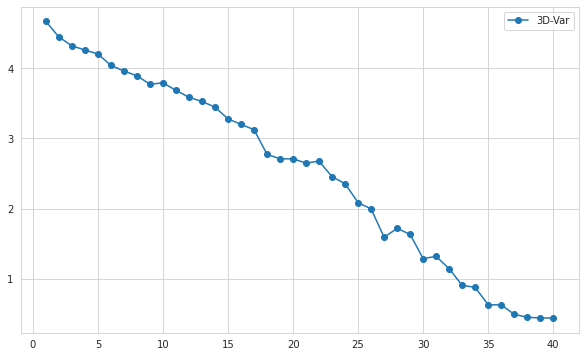

In [165]:
error_min_ls_b = error_ls_b.min(axis=1)
plt.plot(np.arange(1,41, 1), error_min_ls_b[::-1], marker='o',label="3D-Var")
plt.legend()
plt.show()

# 観測を抜く KF

In [90]:
def del_kf(del_num, param):
    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    del_key = np.random.choice(N, del_num, replace=False)
    H = np.eye(N)
    H = np.delete(H, del_key, 0)
    R = np.eye(N - del_num)
    error_x_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))

    for i in range(1,600):#data_noise.shape[0]
        if np.abs(np.abs(x_a).max()) > 300.0:
            print("got nan")
            return np.nan
        m = np.zeros((N, N))
        for j in range(0, N):
            e_j = np.zeros((N))
            e_j[j] = delta
            m[:, j] = (l96_synoptic(x_a + e_j) - l96_synoptic(x_a)) / delta
        x_f = l96_synoptic(x_a)
        p_f = m @ p_a @ m.T
        K = p_f @ H.T @ np.linalg.inv(H @ p_f @ H.T + R)
        y = np.delete(data_noise[i], del_key)
        x_a = x_f + K @ (y - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        p_a = p_a * param
        error_x_ls.append(RMSE(x_a, data[i]))
    error_x_np = np.array(error_x_ls)
    return error_x_np[200:].mean()

In [ ]:
num_infls = 5
error_ls_kf = np.zeros((N, num_infls))
kf_param_ls = np.linspace(1.01, 1.3, num_infls)
for del_num in range(0, N):
    print(del_num)
    for i in range(num_infls):
        error_ls_kf[del_num, i] = del_kf(del_num, kf_param_ls[i])

0
1
2
3
4
5
6
7
8
9
10
11


In [147]:
np.save('data/kf.npy', error_ls_kf)

In [148]:
error_ls_kf[32]

array([       nan,        nan,        nan,        nan, 1.15609032])

In [149]:
error_min_ls_kf = error_ls_kf.min(axis=1)

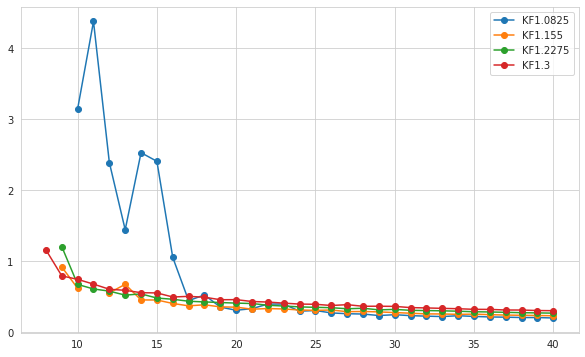

In [150]:
for i in range(1, num_infls):
    plt.plot(np.arange(1,41, 1),error_ls_kf[::-1, i], marker='o',label="KF{}".format(kf_param_ls[i]))
plt.legend()
plt.show()

In [185]:
def del_kf_random_eachtime(del_num, param):
    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    
    R = np.eye(N - del_num)
    error_x_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))
    x_a_ls = []
    p_a_ls = []
    for i in range(1,600):#data_noise.shape[0]
        del_key = np.random.choice(N, del_num, replace=False)
        H = np.delete(np.eye(N), del_key, 0)
        if np.abs(np.abs(x_a).max()) > 300.0:
            print("got nan")
            return np.nan
        m = np.zeros((N, N))
        for j in range(0, N):
            e_j = np.zeros((N))
            e_j[j] = delta
            m[:, j] = (l96_synoptic(x_a + e_j) - l96_synoptic(x_a)) / delta
        x_f = l96_synoptic(x_a)
        p_f = m @ p_a @ m.T
        K = p_f @ H.T @ np.linalg.inv(H @ p_f @ H.T + R)
        y = np.delete(data_noise[i], del_key)
        x_a = x_f + K @ (y - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        p_a = p_a * param
        error_x_ls.append(RMSE(x_a, data[i]))
        x_a_ls.append(x_a)
        p_a_ls.append(p_a)
    x_a_np = np.array(x_a_ls)
    p_a_np = np.array(p_a_ls)
    p_f_np = np.array(p_f_ls)
    np.save("data/x_a_random_del{}.npy".format(del_num),x_a_np)
    np.save("data/p_a_random_del{}.npy".format(del_num),p_a_np)
    error_x_np = np.array(error_x_ls)
    return error_x_np[200:].mean()

In [ ]:
num_infls = 5
error_ls_kf = np.zeros((N, num_infls))
kf_param_ls = np.linspace(1.01, 1.3, num_infls)
for del_num in range(0, N):
    print(del_num)
    for i in range(num_infls):
        error_ls_kf[del_num, i] = del_kf_random_eachtime(del_num, kf_param_ls[i])

0


In [ ]:
np.save('data/kf_eachtime.npy', error_ls_kf)

In [145]:
error_ls_kf = np.load('data/kf_eachtime.npy')

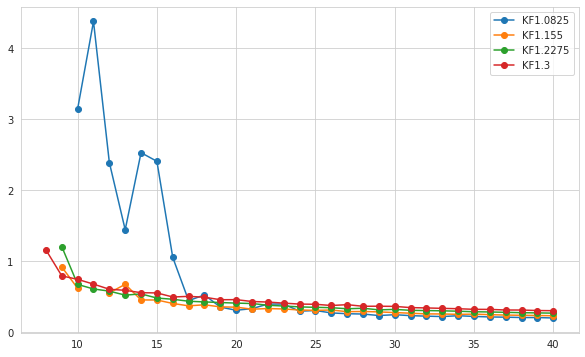

In [146]:
for i in range(1, num_infls):
    plt.plot(np.arange(1,41, 1),error_ls_kf[::-1, i], marker='o',label="KF{}".format(kf_param_ls[i]))
plt.legend()
plt.show()

In [182]:
def del_kf_fix(del_num, param):
    x_s = data_noise[0]
    p_s = a * np.eye(N)
    x_a = random_xa(x_s)
    p_a = a * np.eye(N)
    
    R = np.eye(N - del_num)
    error_x_ls = []
    error_x_ls.append(RMSE(x_a, data[0]))
    del_key = np.arange(del_num)
    H = np.delete(np.eye(N), del_key, 0)
    x_a_ls = []
    p_a_ls = []
    p_f_ls = []
    for i in range(1,600):#data_noise.shape[0]
        if np.abs(np.abs(x_a).max()) > 3000.0:
            print("got nan")
            x_a_np = np.array(x_a_ls)
            p_a_np = np.array(p_a_ls)
            p_f_np = np.array(p_f_ls)
            np.save("data/x_a_del{}.npy".format(del_num),x_a_np)
            np.save("data/p_a_del{}.npy".format(del_num),p_a_np)
            np.save("data/p_f_del{}.npy".format(del_num),p_f_np)
            return np.nan
        m = np.zeros((N, N))
        for j in range(0, N):
            e_j = np.zeros((N))
            e_j[j] = delta
            m[:, j] = (l96_synoptic(x_a + e_j) - l96_synoptic(x_a)) / delta
        x_f = l96_synoptic(x_a)
        p_f = m @ p_a @ m.T
        K = p_f @ H.T @ np.linalg.inv(H @ p_f @ H.T + R)
        y = np.delete(data_noise[i], del_key)
        x_a = x_f + K @ (y - H @ x_f)
        p_a = (np.eye(N) - K @ H) @ p_f
        x_a_ls.append(x_a)
        p_a_ls.append(p_a)
        p_f_ls.append(p_f)
        p_a = p_a * param
        error_x_ls.append(RMSE(x_a, data[i]))
    error_x_np = np.array(error_x_ls)
    x_a_np = np.array(x_a_ls)
    p_a_np = np.array(p_a_ls)
    p_f_np = np.array(p_f_ls)
    np.save("data/x_a_del{}.npy".format(del_num),x_a_np)
    np.save("data/p_a_del{}.npy".format(del_num),p_a_np)
    np.save("data/p_f_del{}.npy".format(del_num),p_f_np)
    return error_x_np[200:].mean()

In [183]:
num_infls = 5
error_ls_kf = np.zeros((N, num_infls))
kf_param_ls = np.linspace(1.01, 1.3, num_infls)
for del_num in range(0, N):
    print(del_num)
    for i in range(num_infls):
        error_ls_kf[del_num, i] = del_kf_fix(del_num, kf_param_ls[i])

0


KeyboardInterrupt: 

In [ ]:
np.save('data/kf_fix.npy', error_ls_kf)

In [137]:
error_ls_kf = np.load('data/kf_fix.npy')

In [138]:
error_ls_kf

array([[3.6144661 , 0.19692931, 0.22773434, 0.26495047, 0.29941596],
       [3.81667946, 0.20539023, 0.23152985, 0.26989127, 0.3056556 ],
       [3.86180302, 0.2103165 , 0.2334384 , 0.27256913, 0.31170812],
       [4.21874541, 0.22173133, 0.24568941, 0.287565  , 0.32650207],
       [4.48066439, 0.22928075, 0.25842676, 0.30471231, 0.35530294],
       [4.48277063, 3.09203072, 0.26783876, 0.34836544, 0.45124001],
       [4.7869245 , 2.10752901, 2.64611656,        nan, 1.60946836],
       [4.89534604,        nan, 1.88098723,        nan,        nan],
       [4.90401521, 5.30527037,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [4.70498337,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,   

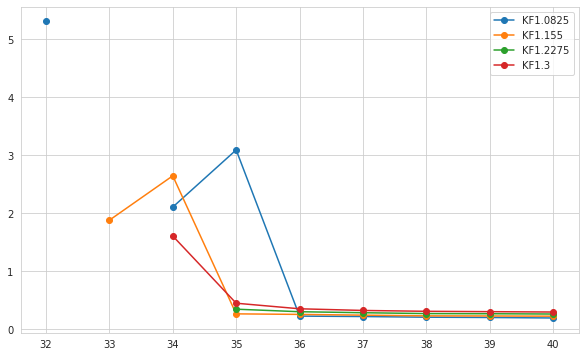

In [143]:
for i in range(1, num_infls):
    plt.plot(np.arange(1,41, 1), error_ls_kf[::-1, i], marker='o',label="KF{}".format(kf_param_ls[i]))
plt.legend()

In [234]:
error_ls_kf_tmp = del_kf_fix(10, kf_param_ls[2])

<ipython-input-4-b40759b8a282>:4: RuntimeWarning: overflow encountered in double_scalars
  d[i] = (x[(i+1)%N] - x[i-2]) * x[i-1] - x[i] + F
<ipython-input-4-b40759b8a282>:4: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = (x[(i+1)%N] - x[i-2]) * x[i-1] - x[i] + F
<ipython-input-4-b40759b8a282>:13: RuntimeWarning: invalid value encountered in add
  x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


In [235]:
error_ls_kf_tmp

nan

In [236]:
x_a_np_tmp = np.load("data/x_a_del{}.npy".format(10))
p_a_np_tmp = np.load("data/p_a_del{}.npy".format(10))

In [ ]:
x_a_np_tmp = np.load("data/x_a_random_del{}.npy".format(7))
p_a_np_tmp = np.load("data/p_a_random_del{}.npy".format(7))

In [237]:
p_a_np_tmp.shape

(599, 40, 40)

In [267]:
max_ls = np.zeros((599))

In [270]:
for i in range(599):
    max_ls[i] = np.abs(p_a_np_tmp[i]).max()

In [271]:
p_a_np_tmp.shape

(599, 40, 40)

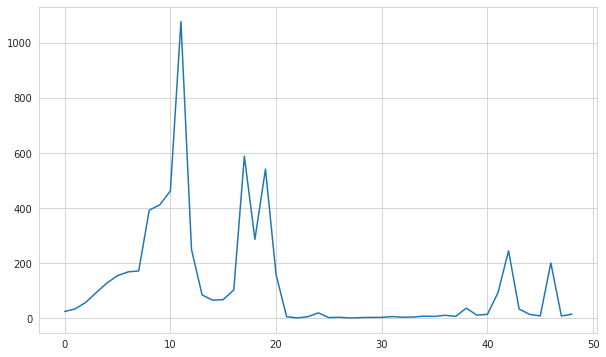

In [272]:
plt.plot(max_ls)

<AxesSubplot:>

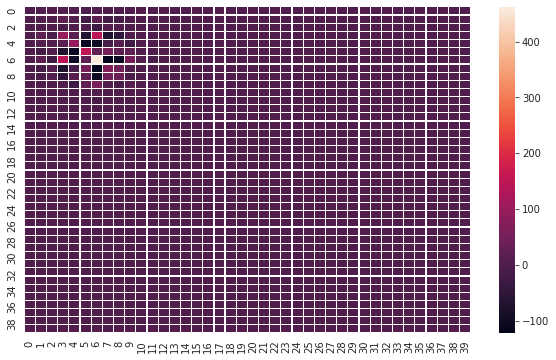

In [282]:
sns.heatmap(p_a_np_tmp[10], linewidths=.2)

<AxesSubplot:>

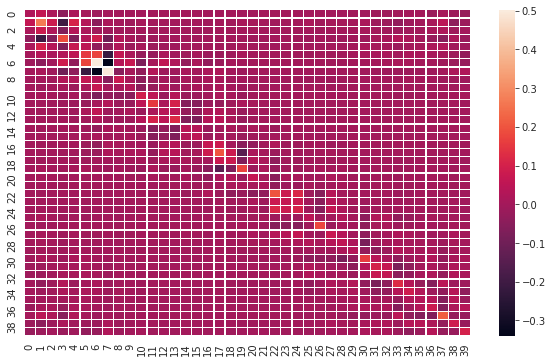

In [221]:
sns.heatmap(p_a_np_tmp[580], linewidths=.2)

In [178]:
p_a_np_tmp[300]

array([[ 0.19476314,  0.055584  , -0.02837059, ..., -0.10361678,
        -0.08023764,  0.06808961],
       [ 0.055584  ,  1.67812133,  1.002349  , ...,  0.10048142,
        -0.01796698, -0.23945765],
       [-0.02837059,  1.002349  ,  0.74711737, ...,  0.03238895,
         0.01467412, -0.10420079],
       ...,
       [-0.10361678,  0.10048142,  0.03238895, ...,  0.18984058,
         0.1026988 , -0.07953799],
       [-0.08023764, -0.01796698,  0.01467412, ...,  0.1026988 ,
         0.14075834,  0.00989321],
       [ 0.06808961, -0.23945765, -0.10420079, ..., -0.07953799,
         0.00989321,  0.11555525]])

# EnKF PO法

In [283]:
a

25

In [515]:
def po(m, inflation):
    x_s = data_noise[0]
    x_a_m = []
    for i in range(m):
        x_a_m.append(random_xa(x_s) + np.random.randn(N))
    x_a_m = np.array(x_a_m)
    error_x_ls = []
    noise_ls = []
    p_ls = []
    x_a_mean = x_a_m.mean(axis=0)
    error_x_ls.append(RMSE(x_a_mean, data[0]))
    noise_ls.append(RMSE(data_noise[0], data[0]))
    p_ls.append(0.0)
    H = np.eye(N)
    R = np.eye(N)

    for i in range(1,600):#data_noise.shape[0]
        if i % 200 == 0:
            print(i)
        x_f_m = np.zeros_like(x_a_m)
        for k in range(m):
            x_f_m[k] = l96_synoptic(x_a_m[k])
        dxf = x_f_m - x_f_m.mean(axis=0)
        dxf = dxf.T
        dyf = np.array([H @ x_f_m[idx] - H @ x_f_m.mean(axis=0) for idx in range(m)]) * inflation
        K = dxf @ dyf.T @ np.linalg.inv(dyf @ dyf.T + (m - 1)*R)
        for k in range(m):
            x_a_m[k] = x_f_m[k] + K @ (data_noise[i] + np.random.randn(N) - H @ x_f_m[k])
        x_a_mean = x_a_m.mean(axis=0)
        error_x_ls.append(RMSE(x_a_mean, data[i]))
        noise_ls.append(RMSE(data_noise[i], data[i]))
        p_ls.append(np.trace((1 - K @ H)@dxf@dxf.T@(1-K@H).T + K @R @ K.T))
    error_x_np = np.array(error_x_ls)
    noise_np = np.array(noise_ls)
    p_np = np.array(p_ls)
    return error_x_np, noise_np, p_np


In [524]:
error_x_np, noise_np, p_np = po(40, 1.0)

200
400


In [525]:
error_x_np[200:].mean()

4.824373980724122

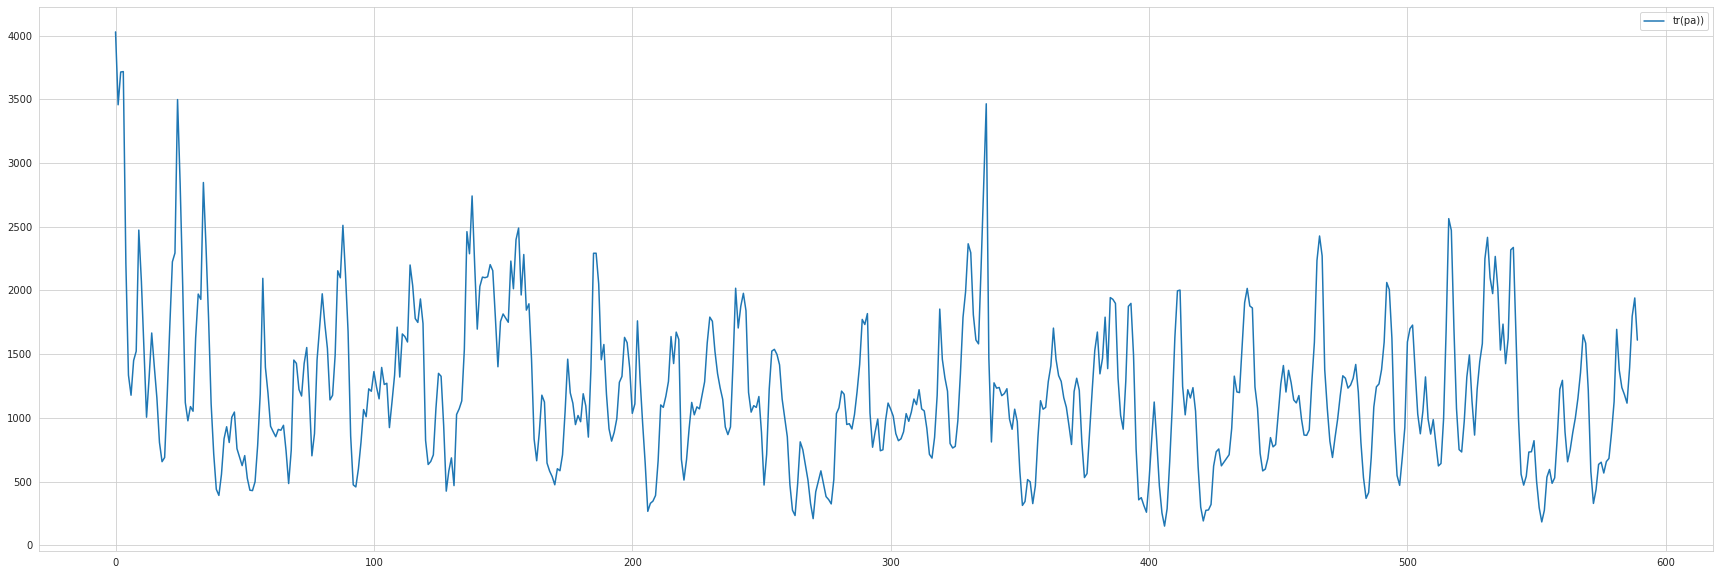

In [526]:
plt.figure(figsize=(30, 10))
#plt.plot(error_x_np, label="RMSE(x_a - x_true)")
#plt.plot(noise_np, label="RMSE(y - y_true)")
plt.plot(p_np[10:], label="tr(pa))")
plt.legend()
plt.savefig("graph/EnKF.png")
plt.show()

200
400
200
400
200
400
200
400
200
400
200
400


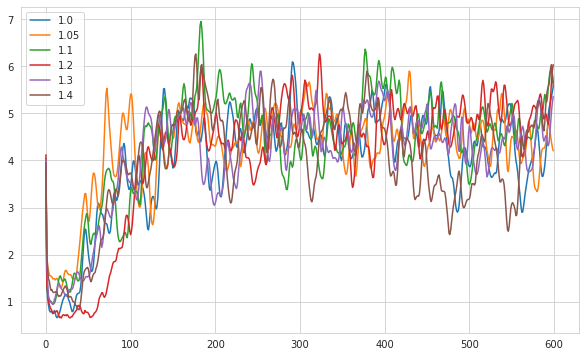

In [505]:
fig = plt.figure()

for i in [1.0, 1.05, 1.1, 1.2, 1.3, 1.4]:
    error_x_np, noise_np = po(40, i)
    plt.plot(error_x_np, label="{}".format(i))
plt.legend()
plt.show()

200
400
200
400
200
400
200
400
200
400
200
400


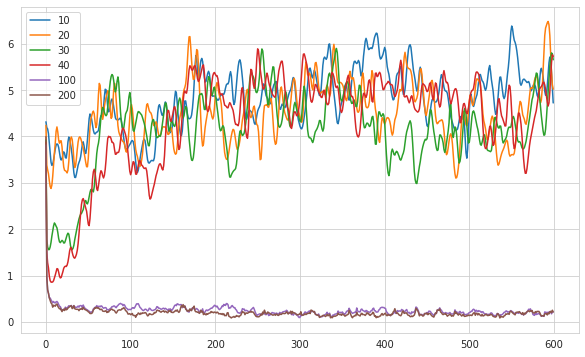

In [529]:
fig = plt.figure()

for i in [10, 20, 30, 40, 100, 200]:
    error_x_np, noise_np,_ = po(i, 1.02)
    plt.plot(error_x_np, label="{}".format(i))
plt.legend()
plt.show()

### LETKF

In [69]:
def letkf(m, infl, cov_infl, sigma):
    ### 初期化
    x_s = data_noise[0]
    x_a_m = []
    for i in range(m):
        x_a_m.append(random_xa(x_s) + np.random.randn(N))
    x_a_m = np.array(x_a_m)
    error_x_ls = []
    noise_ls = []
    p_ls = []
    x_a_mean = x_a_m.mean(axis=0)
    error_x_ls.append(RMSE(x_a_mean, data[0]))
    noise_ls.append(RMSE(data_noise[0], data[0]))
    p_ls.append(0.0)
    H = np.eye(N)
    R = np.eye(N)
            
    for i in range(1,600):#data_noise.shape[0]
        if i % 200 == 0:
            print(i)
        x_f_m = np.zeros_like(x_a_m)
        for k in range(m):
            x_f_m[k] = l96_synoptic(x_a_m[k])
        x_f_mean = x_f_m.mean(axis=0)
        dxf = (x_f_m - x_f_mean).T
        dyf = np.array([H @ x_f_m[idx] - H @ x_f_mean for idx in range(m)]).T # * infl これいる？
        P_a_tilde_preinv = np.eye(m) * (m - 1)/ (cov_infl) + dyf.T @ np.linalg.inv(R) @ dyf
        U, d, UT = np.linalg.svd(P_a_tilde_preinv)
        D = np.diag(d)
        P_a_tilde = U @ np.linalg.inv(D) @ UT
        rhs =  dxf @ (P_a_tilde @ dyf.T @ np.linalg.inv(R) @ (data_noise[i] - H @ x_f_mean) + np.sqrt(m-1) * U @ np.sqrt(np.linalg.inv(D)) @ UT)
        x_a_m = np.broadcast_to(x_f_mean, (m, x_f_mean.shape[0])) + rhs.T
        x_a_mean = x_a_m.mean(axis=0)
        error_x_ls.append(RMSE(x_a_mean, data[i]))
        noise_ls.append(RMSE(data_noise[i], data[i]))
    error_x_np = np.array(error_x_ls)
    noise_np = np.array(noise_ls)
    return error_x_np, noise_np

In [ ]:

fig = plt.figure()

for i in [200,500 ,1000]:
    error_x_np, noise_np = letkf(i, 1.05, 1.05, 5)
    plt.plot(error_x_np, label="{}".format(i))
plt.legend()
plt.show()

200
400


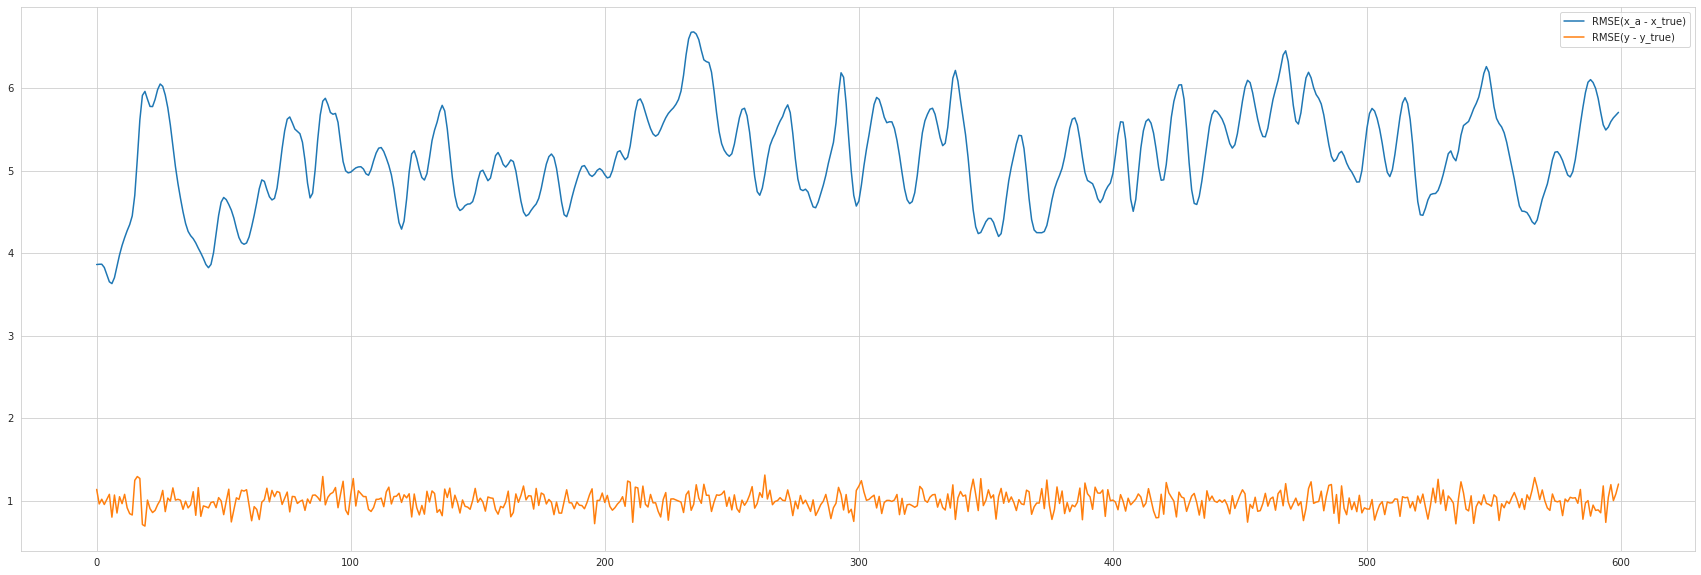

In [67]:
plt.figure(figsize=(30, 10))
plt.plot(error_x_np, label="RMSE(x_a - x_true)")
plt.plot(noise_np, label="RMSE(y - y_true)")
plt.legend()
plt.savefig("graph/KETFK.png")
plt.show()